In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

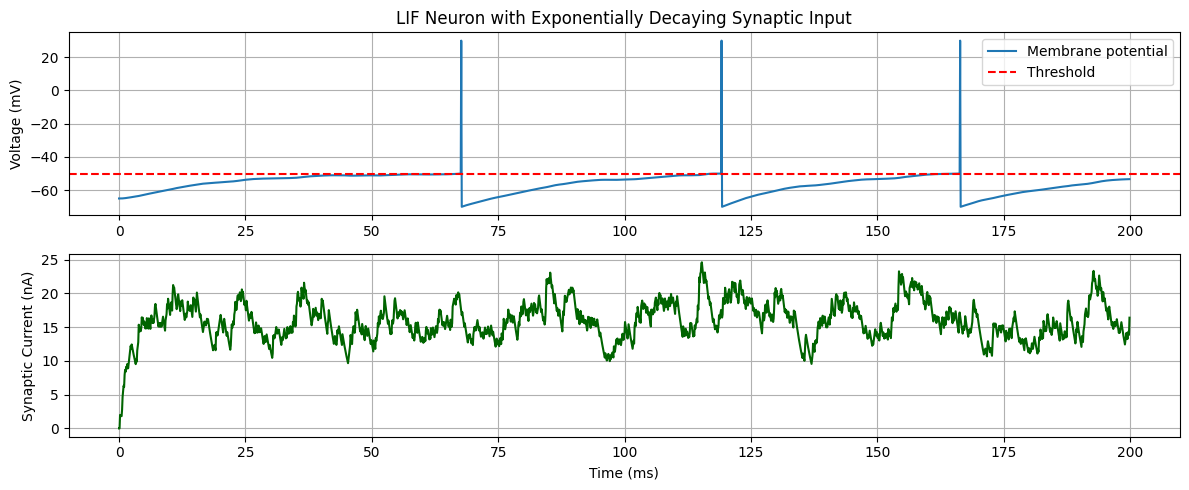

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
T = 200.0      # ms
dt = 0.1       # ms
time = np.arange(0, T, dt)
n_steps = len(time)

# LIF neuron parameters
tau_m = 20.0       # ms
R = 1.0            # MΩ
V_rest = -65.0     # mV
V_reset = -70.0    # mV
V_th = -50.0       # mV

# Synaptic input settings
n_inputs = 100                  # Number of presynaptic neurons
spike_rate = 5.0 / 100         # Average spikes/ms = 5 Hz
tau_syn = 3.0                   # Synaptic time constant (ms)
w = 1.0                         # Synaptic weight per input (nA)

# Generate random input spikes
input_spikes = np.random.rand(n_inputs, n_steps) < spike_rate * dt

# Initialize synaptic current and voltage
I_syn = np.zeros(n_steps)
V = np.zeros(n_steps)
V[0] = V_rest
spikes = []

# Precompute exponential kernel
exp_kernel = np.exp(-np.arange(0, 5*tau_syn, dt)/tau_syn)

# Convolve spikes with exponential kernel
for i in range(n_inputs):
    spike_train = input_spikes[i, :]
    I_syn += np.convolve(spike_train * w, exp_kernel, mode='full')[:n_steps]

# Run LIF neuron
for t in range(1, n_steps):
    dV = (-(V[t-1] - V_rest) + R * I_syn[t-1]) * (dt / tau_m)
    V[t] = V[t-1] + dV

    if V[t] >= V_th:
        V[t-1] = 30  # spike peak for visualization
        V[t] = V_reset
        spikes.append(time[t])

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(time, V, label='Membrane potential')
plt.axhline(V_th, color='r', linestyle='--', label='Threshold')
plt.ylabel('Voltage (mV)')
plt.title('LIF Neuron with Exponentially Decaying Synaptic Input')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, I_syn, color='darkgreen')
plt.ylabel('Synaptic Current (nA)')
plt.xlabel('Time (ms)')
plt.grid()

plt.tight_layout()
plt.show()


In [4]:
nb_inputs  = 100
nb_hidden  = 4
nb_outputs = 2

time_step = 1e-3
nb_steps  = 200

batch_size = 256

dtype = torch.float
device = torch.device("cpu")


In [5]:
freq = 5 # Hz
prob = freq*time_step
mask = torch.rand((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype, requires_grad=False)
x_data[mask<prob] = 1.0

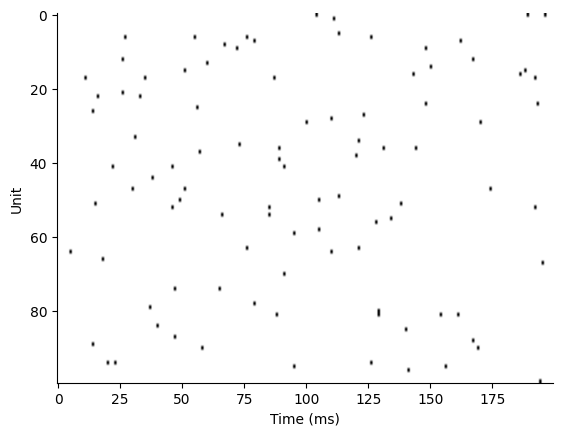

In [6]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()